In [201]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import matplotlib.cm as cm
from scipy.misc import imresize
import cv2
import pandas as pd
import scipy.io as io

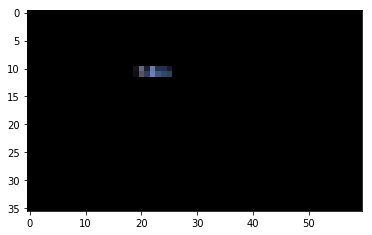

In [202]:
# load the face model
facemodel_mat = io.loadmat('C:/Users/nam young woo/Downloads/Codes/Eye Tracking/Codes/MPIIGaze/6 points-based face model.mat')
facemodel = facemodel_mat['model']
# I have to know about 6 points-based face model

# load the image, annotation and camera parameters.
img=cv2.imread('C:/Users/nam young woo/Downloads/Codes/Eye Tracking/Codes/MPIIGaze/Data/Original/p00/day01/0001.jpg')
anotation_df = pd.read_csv('C:/Users/nam young woo/Downloads/Codes/Eye Tracking/Codes/MPIIGaze/Data/Original/p00/day01/annotation.txt',sep = ' ' ,header= None)
anotation = np.array(anotation_df)
cameraCalib_mat = io.loadmat('C:/Users/nam young woo/Downloads/Codes/Eye Tracking/Codes/MPIIGaze/Data/Original/p00/Calibration/Camera.mat')

#get head pose
headpose_hr = anotation[0][29:32]
headpose_ht = anotation[0][32:35]
hR = cv2.Rodrigues(headpose_hr)[0]
Fc = np.dot(hR ,facemodel) #rotate the face model, which is calcluated from facial landmakr detection
try:
    Fc[0] = Fc[0] + headpose_ht[0]
    Fc[1] = Fc[1] + headpose_ht[1]
    Fc[2] = Fc[2] + headpose_ht[2]
except ValueError:
    print("Fc shape and headpose_ht isn't same!")
    pass

# get the eye center in the original camera cooridnate system.
right_eye_cetter= 0.5 * (Fc[:, 0] + Fc[:, 1])
left_eye_center = 0.5 * (Fc[:, 2] + Fc[:, 3])

# get the gaze target
gaze_target= anotation[0, 26:29]
gaze_target = gaze_target.transpose()

# set the size of normalized eye image
eye_image_width=60
eye_image_height=36

# normalization for the right eye, you can do it for left eye by replacing
# "right_eye_cetter" to "left_eye_center"

eye_img,headpose,gaze=normalizeImg(img,right_eye_cetter,hR,gaze_target,
                                   [eye_image_width, eye_image_height],
                                   cameraCalib['cameraMatrix'])

plt.imshow(eye_img)

# convert the gaze direction in the camera cooridnate system to the angle
# in the polar coordinate system

gaze_theta= np.arcsin(-1 * gaze[1])
gaze_phi= np.arctan2((-1 * gaze[0]), -1 * gaze[2])


# save as above, conver head pose to the polar coordinate system
M = cv2.Rodrigues(headpose)[0]
Zv= M[:, 2]
headpose_theta= np.arcsin(Zv[1])
headpose_phi= np.arctan2(Zv[0], Zv[2])
    

In [203]:
def normalizeImg(inputImg, target_3D, hR, gc, roiSize, cameraMatrix, *args):
    
    nargin = len(args)
    # prepare the data
    # for right eye
    if nargin < 8:
        focal_new=960  #facoal length of the virual camera can be changed as needed.
    if nargin < 9:
        distance_new=600 
# please do not change it or set it to be different value, otherwise the gaze label will be different.
    
    distance= np.linalg.norm(gaze_target)
    z_scale=distance_new / distance
    cam_new= np.array([[focal_new, 0, roiSize[0] / 2], [0.0, focal_new, roiSize[1] /2],  [0, 0, 1.0]])
    scaleMat= np.array([[1.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,z_scale]])
    hRx=hR[:,0]
    forward =(target_3D / distance)
    down = np.cross(forward,hRx)
    down = down / np.linalg.norm(down)
    right = np.cross(down,forward)
    right=right / np.linalg.norm(right)
    rotMat = np.array([right, down, forward]).transpose()
    
    warpMat = np.matmul(np.matmul(cam_new, scaleMat), np.matmul(rotMat, np.linalg.inv(cameraMatrix)));
    img_warped= cv2.warpPerspective(inputImg,warpMat, (roiSize[0], roiSize[1]))
    # ROI size can be error?
    
    # rotatoin normalization
    cnvMat= np.matmul(scaleMat,rotMat)
    hRnew = np.matmul(cnvMat, hR)
    hrnew = cv2.Rodrigues(hRnew)[0]
    htnew= np.matmul(cnvMat,target_3D)
    
    # gaze vector normalizatoin
    gcnew= np.matmul(cnvMat,gc)
    gvnew= gcnew - htnew
    gvnew= gvnew / np.linalg.norm(gvnew)
    return img_warped,hrnew,gvnew